In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Paths and input

# Sampled single-cell data for VAE
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))  
main = main.sample(frac=1.0)
main.reset_index(inplace=True)

# Full SARDANA-097 single-cell data (Leiden clustered)
df_full = pd.read_parquet(
    '/Volumes/T7 Shield/cylinter_input/clean_quant/output_3d_v2/leiden_clustering.parquet'
)

out = os.path.join(os.getcwd(), 'output/cells_per_patch')
if not os.path.exists(out):
    os.makedirs(out)

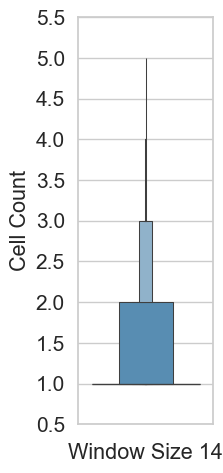

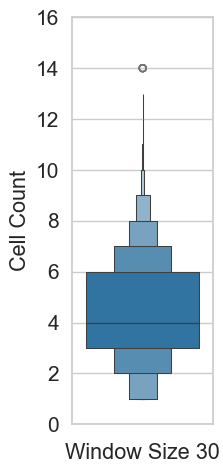

In [3]:
for window_size in [14, 30]:  # in square pixels

    if not os.path.exists(os.path.join(out, f'counts{window_size}.csv')):

        print(f'Working on window size {window_size}.')
        radius = window_size / 2
        
        counts = []
        for i, j in df_sample.iterrows():
            if i % 10000 == 0:
                print(i)
            # Isolate cells in window_size x window_size pixel area, append count to list
            x = j['X_centroid']
            y = j['Y_centroid']
            patch = (
                df_full[(df_full['Y_centroid'].between(y - radius, y + radius)) &
                        (df_full['X_centroid'].between(x - radius, x + radius))].copy()
            )
            counts.append(len(patch))

        plot = pd.DataFrame(
            data={f'Window Size {window_size} pixels squared': 1, 'Cell Count': counts}
        )

        q1, q3 = np.percentile(plot['Cell Count'], [25, 75])
        iqr = q3 - q1
        plot['Q1'] = q1
        plot['Q3'] = q3
        plot['IQR'] = iqr

        plot.to_csv(os.path.join(out, f'counts{window_size}.csv'), index=False)
    else:
        plot = pd.read_csv(os.path.join(out, f'counts{window_size}.csv'))

        plt.rcParams['font.family'] = 'Arial'
        sns.set(font_scale=1.3)
        sns.set_style('whitegrid')
        
        g = sns.catplot(
            data=plot, x=f'Window Size {window_size}', y='Cell Count', kind='boxen',
            hue=f'Window Size {window_size}', palette=['tab:blue'], aspect=0.5,
            facet_kws=dict(despine=False), legend=False
        )
        g.set(xticklabels=[])
        g.set_yticklabels(fontsize=15, weight='normal')
        plt.tight_layout()
        
        plt.savefig(os.path.join(out, f'patch_counts_w{window_size}.pdf'))
        plt.show()
        plt.close('all')
        print()